In [1]:
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
def create_obs_legend(response):
    data = [[c, k] for k, v in response["observables"].items() for c in v["components"]]
    columns = ["component", "variable"]
    df = pd.DataFrame(data, columns=["component", "variable"]).set_index(columns).sort_index()
    return df


def observables_to_dataframe(response):
    data = {k: v["value"] for k, v in response["observables"].items()}
    df = pd.DataFrame(data)
    return df

# Параметры модели

In [3]:
r = requests.post("http://127.0.0.1:2021/get_model_params",
                  json={"model_name": "BR"})

In [4]:
params = {k: pd.DataFrame(v).set_index(["component", "variable"])
          for k, v in r.json().items()}

In [5]:
params["params"]

value
component           variable                       
sodium_current      g_Na                    0.04000
                    E_Na                   50.00000
                    g_Nac                   0.00003
stimulus_protocol   IstimStart             10.00000
                    IstimEnd            50000.00000
                    IstimAmplitude          0.50000
                    IstimPeriod          1000.00000
                    IstimPulseDuration      1.00000
slow_inward_current g_s                     0.00090
membrane            C                       0.01000

In [6]:
params["states"]

,,value
component,variable,
slow_inward_current_d_gate,d,0.0030
slow_inward_current_f_gate,f,0.9940
slow_inward_current,Cai,0.0001
time_dependent_outward_current_x1_gate,x1,0.0001
sodium_current_m_gate,m,0.0110
sodium_current_h_gate,h,0.9880
membrane,V,-84.6240
sodium_current_j_gate,j,0.9750


# Возбудимость

## Пороговый потенциал

In [7]:
p = params["params"].copy()
p.loc[("stimulus_protocol", "IstimAmplitude")] = 0.
p

value
component           variable                       
sodium_current      g_Na                    0.04000
                    E_Na                   50.00000
                    g_Nac                   0.00003
stimulus_protocol   IstimStart             10.00000
                    IstimEnd            50000.00000
                    IstimAmplitude          0.00000
                    IstimPeriod          1000.00000
                    IstimPulseDuration      1.00000
slow_inward_current g_s                     0.00090
membrane            C                       0.01000

In [8]:
u = params["states"].copy()
u.loc[("membrane", "V")] = -30.
u

,,value
component,variable,
slow_inward_current_d_gate,d,0.0030
slow_inward_current_f_gate,f,0.9940
slow_inward_current,Cai,0.0001
time_dependent_outward_current_x1_gate,x1,0.0001
sodium_current_m_gate,m,0.0110
sodium_current_h_gate,h,0.9880
membrane,V,-30.0000
sodium_current_j_gate,j,0.9750


In [9]:
req_dict = {"model_name": "BR",
            
            "kwargs_problem": {"p": p["value"].to_list(),
                               "u0": u["value"].to_list(),
                               "tspan": [0, 2000]},
            
            "kwargs_solve": {"solver": "CVODE_BDF", "dt": 1e-5, "dtmax": 0.5}}
req_dict

{'model_name': 'BR',
 'kwargs_problem': {'p': [0.04,
   50.0,
   3e-05,
   10.0,
   50000.0,
   0.0,
   1000.0,
   1.0,
   0.0009,
   0.01],
  'u0': [0.003, 0.994, 0.0001, 0.0001, 0.011, 0.988, -30.0, 0.975],
  'tspan': [0, 2000]},
 'kwargs_solve': {'solver': 'CVODE_BDF', 'dt': 1e-05, 'dtmax': 0.5}}

In [10]:
r = requests.post("http://127.0.0.1:2021/solve_problem", json=req_dict)
response = r.json()

In [11]:
t = response["time"]
df = observables_to_dataframe(response)

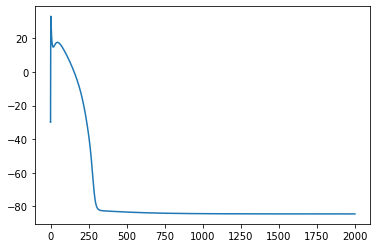

In [12]:
plt.plot(t, df["V"])

## Несколько прогонов с разным V0

In [13]:
V0_array = np.arange(-100, -40, 5)

In [15]:
dfs = []

for V0 in tqdm(V0_array):
    u.loc[("membrane", "V")] = V0
    req_dict["kwargs_problem"]["u0"] = u["value"].to_list()
    
    r = requests.post("http://127.0.0.1:2021/solve_problem", json=req_dict)
    response = r.json()
    
    df = observables_to_dataframe(response)
    df["t"] = response["time"]
    dfs.append(df)

  0%|          | 0/12 [00:00<?, ?it/s]

Text(0, 0.5, 'V, mV')

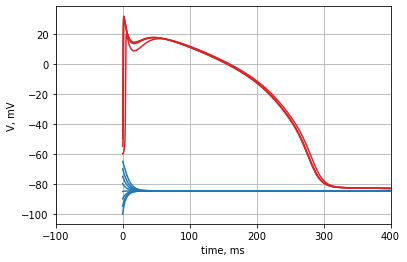

In [16]:
for df, V0 in zip(dfs, V0_array):
    V = df["V"]
    t = df["t"]
    color = "C0" if V.max() < 0 else "C3"
    
    plt.plot(t, V, color=color)
    
plt.xlim(right=400)
plt.grid()

plt.xlabel("time, ms")
plt.ylabel("V, mV")

Text(0, 0.5, 'V, mV')

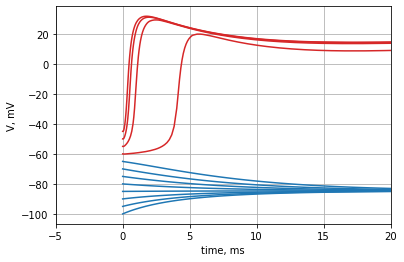

In [17]:
for df, V0 in zip(dfs, V0_array):
    V = df["V"]
    t = df["t"]
    color = "C0" if V.max() < 0 else "C3"
    
    plt.plot(t, V, color=color)
    
plt.xlim(-5, 20)
plt.grid()

plt.xlabel("time, ms")
plt.ylabel("V, mV")